In [79]:
import sys
import os
import cv2
import itertools
import pickle
import struct
import numpy as np
import scipy.io
from PIL import Image, ImageFilter
from random import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def pickle_operating(fname, item):
    # save or load the pickle file.
    file_name = '%s.pickle' % fname
    print(file_name)
    if not item:
        with open(file_name, 'rb') as fs:
            item = pickle.load(fs)
            return item
    else:
        with open(file_name, 'wb') as fs:
            pickle.dump(item, fs, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
def load_MNIST(dataset="training", path='../MNIST/'):
    if dataset is "training":
        f_img = os.path.join(path, 'train-images.idx3-ubyte')
        f_labels = os.path.join(path, 'train-labels.idx1-ubyte')
    else:
        f_img = os.path.join(path, 't10k-images.idx3-ubyte')
        f_labels = os.path.join(path, 't10k-labels.idx1-ubyte')

    with open(f_labels, 'rb') as flabels:
        magic, num = struct.unpack(">II", flabels.read(8))
        labels = np.fromfile(flabels, dtype=np.int8)

    with open(f_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        imgs = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows, cols)
    '''
    data = [] 
    for i in range(len(imgs)):
        data.append((imgs[i], labels[i]))
    '''
    return imgs, labels

In [62]:
def deskew(img):
    m = cv2.moments(img)
    SZ=40
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02'] 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [81]:
imgs_train, labels_train = load_MNIST('training')
imgs_test, labels_test = load_MNIST('testing')

In [82]:
def preprocess_MNIST_imgs(data):
    imgs = []
    for img in data:
        img = deskew(img)
        image = img.flatten()
        imgs.append(image)
    return imgs

In [83]:
def pca(X_train, n_feature):
    pca = PCA(n_components=n_feature)
    pca.fit(X_train)
    return pca

In [84]:
MNIST_data = {}
data_train = preprocess_MNIST_imgs(imgs_train)
data_test = preprocess_MNIST_imgs(imgs_test)
MNIST_data['train'], MNIST_data['test'] = [data_train, labels_train], [data_test, labels_test]

Number of features: 1600


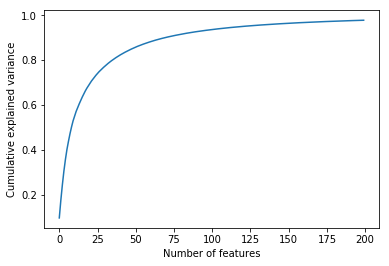

In [118]:
mnist_pca = pca(MNIST_data['train'][0], 200)
print("Number of features: %s" % len(MNIST_data['train'][0][0]))

plt.plot(np.cumsum(mnist_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.show()

In [133]:
mnist_pca = pca(MNIST_data['train'][0], 16)

MNIST_data['train'][0] = mnist_pca.transform(MNIST_data['train'][0])
MNIST_data['test'][0] = mnist_pca.transform(MNIST_data['test'][0])
MNIST_data['train'] = [(MNIST_data['train'][0][i], MNIST_data['train'][1][i]) for i in range(len(MNIST_data['train'][0]))]
MNIST_data['test'] = [(MNIST_data['test'][0][i], MNIST_data['test'][1][i]) for i in range(len(MNIST_data['test'][0]))]
pickle_operating('MNIST_data_2', MNIST_data)

MNIST_data_2.pickle


In [3]:
def flatten_image(img):
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [103]:
structures = [x for x in os.walk('../Caltech10/')]

In [123]:
def preprocess_Caltech_imgs(folders):
    dataset = {'categories': {}, 'data': {}}
    data = []
    label = 0
    size = (128, 128)
    for f in folders:
        dataset['categories'][f[0]] = label
        dataset['data'][label] = []
        for i in f[2]:
            #image = Image.open("%s/%s"%(f[0], i)).resize(size)
            #image = image.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
            #im_data = list(image.getdata())
            img = cv2.imread("%s/%s"%(f[0], i))
            resized_img = cv2.resize(img, size)
            im_data = resized_img.flatten()
            dataset['data'][label].append((im_data, label))
        label += 1
    return dataset

In [124]:
def train_test_splitting(size, data):
    train_data, test_data = [], []
    for i in data.keys():
        x = range(len(data[i]))
        shuffle(x)
        train_size = int(size*len(data[i]))
        train_indexes, test_indexes = x[:train_size], x[train_size:]
        train_data.extend(np.array(data[i])[train_indexes]) 
        test_data.extend(np.array(data[i])[test_indexes])
    del train_data[0]
    del test_data[0]
    return train_data, test_data

In [128]:
dataset_temp = preprocess_Caltech_imgs(structures)
caltech_data = {}
caltech_data['train'], caltech_data['test'] = [], []
caltech_data['train'], caltech_data['test'] = train_test_splitting(0.5, dataset_temp['data'])
pickle_operating('Caltech_data_3', caltech_data)

Caltech_data_3.pickle


Number of features: 49152


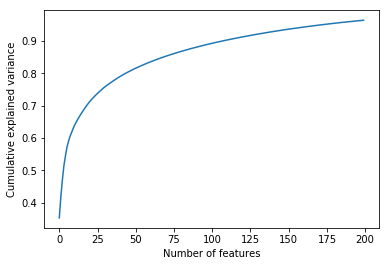

In [129]:
caltech_train = [x[0] for x in caltech_data['train']]
caltech_test = [x[0] for x in caltech_data['test']]
print("Number of features: %s" % len(caltech_train[0]))
caltech_pca = pca(caltech_train, 200)

plt.plot(np.cumsum(caltech_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.show()

In [132]:
caltech_pca = pca(caltech_train, 50)
caltech_train_pca = caltech_pca.transform(caltech_train)
caltech_test_pca = caltech_pca.transform(caltech_test)
caltech_data['train'] = [(caltech_train_pca[i], caltech_data['train'][i][1]) for i in range(len(caltech_train_pca))]
caltech_data['test'] = [(caltech_test_pca[i], caltech_data['test'][i][1]) for i in range(len(caltech_test_pca))]
pickle_operating('Caltech_data_3', caltech_data)

Caltech_data_3.pickle
